### Hello 
In this notebook I m going to implement this paper for the for the ECG beat classification

### Refrence paper link: 
 https://arxiv.org/pdf/2502.00497

In [65]:
!pip install -q wfdb

In [66]:
# Data Handling and Processing
import numpy as np
import pandas as pd
import os
import shutil
import csv
import itertools
import collections

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signal Processing
import pywt
from scipy import stats
import wfdb

## MIT BIH Arrhytmia dataset

In [67]:
base_dir = '/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0'

In [68]:
def extract_beats_from_multiple_files(record_list):
    beat_labels = []
    beats = []
    
    for name in record_list:
        record_name = f"/kaggle/input/mit-ar/mit-bih-arrhythmia-database-1.0.0/{name}"  
        
        try:
            record = wfdb.rdrecord(record_name, channels=[0]) 
            annotation = wfdb.rdann(record_name, 'atr')
            
            # Resample signal to 125 Hz from 360 Hz
            signal = record.p_signal.flatten()  
            # print(signal)
            # print(f"The count of the dat file: {len(signal)}")
            
            # print(len(signal))
            fs = record.fs  
            # print(fs) # 360 hz original
            
            # Get R-peak locations and annotations
            r_peaks = annotation.sample 
            # print(r_peaks)

            labels = annotation.symbol
            window_size = 257
            
            for i in range(1, len(r_peaks) - 1):  # Ignore first & last beats
                # print(i, "-> " ,r_peaks[i])
                start = max(0, r_peaks[i] - window_size // 2)
                # print(i,"-> ", start)
                end = min(len(signal), r_peaks[i] + window_size // 2 )
                # print(i,"-> ", end)
                beat = signal[start:end + 1]
                # print(len(beat))

                # Append only if the extracted beat matches the window size
                if len(beat) == 257:
                    beats.append(beat)
                    beat_labels.append(labels[i])
                    
        except Exception as e:
            print(f"Error processing record {name}: {e}")
            continue
    
    return beat_labels, beats

# Your record list
record_list = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', 
               '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
               '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
               '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
               '222', '223', '228', '230', '231', '232', '233', '234']

# Extract beats and labels
labels, extracted_beats = extract_beats_from_multiple_files(record_list)

# Basic validation
print(f"Total beats extracted: {len(extracted_beats)}")
print(f"Total labels: {len(labels)}")
print(f"Length of first beat: {len(extracted_beats[0]) if extracted_beats else 'N/A'}")

Total beats extracted: 112529
Total labels: 112529
Length of first beat: 257


In [69]:
print("Converting beats to array...")
signals = np.array(extracted_beats)  

print("Creating DataFrame with 257 columns...")
signal_columns = [f"signal_{i}" for i in range(257)] 
df = pd.DataFrame(signals, columns=signal_columns)
df["qrs_label"] = labels

# Save to CSV
csv_path = "mitbih_beats_expanded.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved as '{csv_path}'")

# Validate the CSV
print("Validating CSV...")
df_loaded = pd.read_csv(csv_path)
print(f"CSV Shape: {df_loaded.shape}")
print(f"Sample data:\n{df_loaded.head()}")

# Validate signals and labels shapes
signals_loaded = df_loaded[[f"signal_{i}" for i in range(257)]].values
labels_loaded = df_loaded["qrs_label"].values
print(f"Signals Shape: {signals_loaded.shape}")
print(f"Labels Shape: {labels_loaded.shape}")

Converting beats to array...
Creating DataFrame with 257 columns...
CSV saved as 'mitbih_beats_expanded.csv'
Validating CSV...
CSV Shape: (112529, 258)
Sample data:
   signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0    -0.285    -0.280    -0.300    -0.300    -0.305    -0.295    -0.300   
1    -0.335    -0.335    -0.330    -0.325    -0.345    -0.350    -0.345   
2    -0.355    -0.360    -0.355    -0.365    -0.355    -0.350    -0.340   
3    -0.330    -0.315    -0.320    -0.320    -0.330    -0.345    -0.340   
4    -0.320    -0.315    -0.335    -0.335    -0.345    -0.335    -0.325   

   signal_7  signal_8  signal_9  ...  signal_248  signal_249  signal_250  \
0    -0.310    -0.310    -0.305  ...      -0.330      -0.330      -0.320   
1    -0.335    -0.330    -0.330  ...      -0.300      -0.300      -0.310   
2    -0.355    -0.350    -0.365  ...      -0.295      -0.295      -0.290   
3    -0.335    -0.330    -0.335  ...      -0.305      -0.310      -0.315   
4   

In [70]:
import pandas as pd

# Load dataset
csv_file = "/kaggle/working/mitbih_beats_expanded.csv"
df = pd.read_csv(csv_file)

# Separate the last column
label_column = df.iloc[:, -1]  # Extract last column (qrs_label)
df = df.iloc[:, :-1].astype(float)  # Convert all other columns to float

# Reattach the label column
df["qrs_label"] = label_column  # Add label back as the last column

# Save back to CSV
df.to_csv("/kaggle/working/mitbih_beats_expanded.csv", index=False)

# Display info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112529 entries, 0 to 112528
Columns: 258 entries, signal_0 to qrs_label
dtypes: float64(257), object(1)
memory usage: 221.5+ MB
None


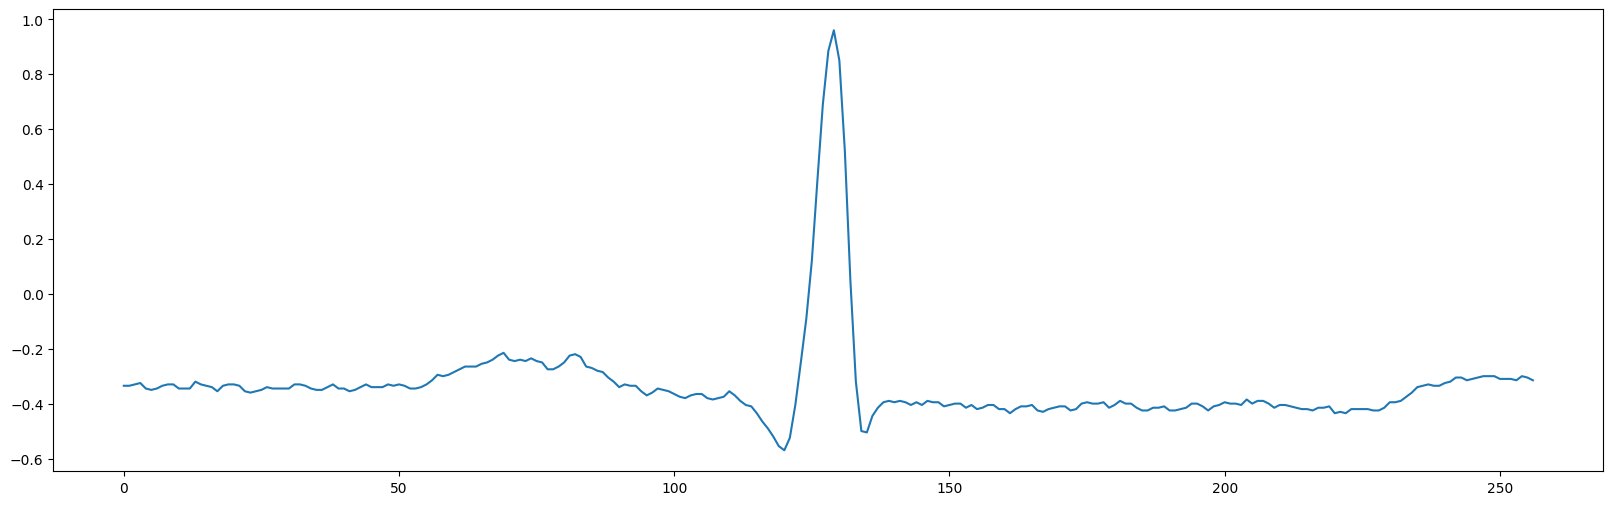

In [71]:
plt.figure(figsize = (20, 6))
beat = extracted_beats[1]
plt.plot(beat)

In [72]:
data = pd.read_csv('/kaggle/working/mitbih_beats_expanded.csv')

data.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_248,signal_249,signal_250,signal_251,signal_252,signal_253,signal_254,signal_255,signal_256,qrs_label
0,-0.285,-0.280,-0.300,-0.300,-0.305,-0.295,-0.300,-0.310,-0.310,-0.305,...,-0.330,-0.330,-0.320,-0.310,-0.300,-0.300,-0.320,-0.320,-0.315,N
1,-0.335,-0.335,-0.330,-0.325,-0.345,-0.350,-0.345,-0.335,-0.330,-0.330,...,-0.300,-0.300,-0.310,-0.310,-0.310,-0.315,-0.300,-0.305,-0.315,N
2,-0.355,-0.360,-0.355,-0.365,-0.355,-0.350,-0.340,-0.355,-0.350,-0.365,...,-0.295,-0.295,-0.290,-0.280,-0.290,-0.295,-0.310,-0.295,-0.285,N
3,-0.330,-0.315,-0.320,-0.320,-0.330,-0.345,-0.340,-0.335,-0.330,-0.335,...,-0.305,-0.310,-0.315,-0.320,-0.315,-0.305,-0.305,-0.295,-0.310,N
4,-0.320,-0.315,-0.335,-0.335,-0.345,-0.335,-0.325,-0.330,-0.315,-0.335,...,-0.290,-0.310,-0.295,-0.285,-0.280,-0.300,-0.290,-0.295,-0.290,N


In [73]:
data.iloc[:, -1].unique()

array(['N', 'A', 'V', '~', '|', 'Q', '/', 'f', '+', 'x', 'F', 'j', 'L',
       'a', 'J', 'R', '[', '!', ']', 'E', 'S', '"', 'e'], dtype=object)

In [74]:
data.iloc[:, -1].value_counts().reset_index()

,qrs_label,count
0,N,75003
1,L,8070
2,R,7254
3,V,7129
4,/,7022
5,A,2544
6,+,1244
7,f,982
8,F,802
9,~,614


In [75]:
labels = ["N", "V", "F"]
data['qrs_label'] = data.iloc[:, -1].apply(lambda x: x if x in labels else 'Q')

In [76]:
data.iloc[:, -1].value_counts().reset_index()

,qrs_label,count
0,N,75003
1,Q,29595
2,V,7129
3,F,802


In [77]:
print(data.head())
print(f"The shape of the dataset is: {data.shape}")

   signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0    -0.285    -0.280    -0.300    -0.300    -0.305    -0.295    -0.300   
1    -0.335    -0.335    -0.330    -0.325    -0.345    -0.350    -0.345   
2    -0.355    -0.360    -0.355    -0.365    -0.355    -0.350    -0.340   
3    -0.330    -0.315    -0.320    -0.320    -0.330    -0.345    -0.340   
4    -0.320    -0.315    -0.335    -0.335    -0.345    -0.335    -0.325   

   signal_7  signal_8  signal_9  ...  signal_248  signal_249  signal_250  \
0    -0.310    -0.310    -0.305  ...      -0.330      -0.330      -0.320   
1    -0.335    -0.330    -0.330  ...      -0.300      -0.300      -0.310   
2    -0.355    -0.350    -0.365  ...      -0.295      -0.295      -0.290   
3    -0.335    -0.330    -0.335  ...      -0.305      -0.310      -0.315   
4    -0.330    -0.315    -0.335  ...      -0.290      -0.310      -0.295   

   signal_251  signal_252  signal_253  signal_254  signal_255  signal_256  \
0      -0.310  

In [78]:
print("Encoding labels manually...")
label_mapping = {'N': 0, 'V': 1, 'F': 2, 'Q': 3}  # Custom mapping
data["qrs_label"] = data["qrs_label"].map(label_mapping)

Encoding labels manually...


In [79]:
X = data.iloc[:, :-1]
X.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_247,signal_248,signal_249,signal_250,signal_251,signal_252,signal_253,signal_254,signal_255,signal_256
0,-0.285,-0.280,-0.300,-0.300,-0.305,-0.295,-0.300,-0.310,-0.310,-0.305,...,-0.32,-0.330,-0.330,-0.320,-0.310,-0.300,-0.300,-0.320,-0.320,-0.315
1,-0.335,-0.335,-0.330,-0.325,-0.345,-0.350,-0.345,-0.335,-0.330,-0.330,...,-0.30,-0.300,-0.300,-0.310,-0.310,-0.310,-0.315,-0.300,-0.305,-0.315
2,-0.355,-0.360,-0.355,-0.365,-0.355,-0.350,-0.340,-0.355,-0.350,-0.365,...,-0.29,-0.295,-0.295,-0.290,-0.280,-0.290,-0.295,-0.310,-0.295,-0.285
3,-0.330,-0.315,-0.320,-0.320,-0.330,-0.345,-0.340,-0.335,-0.330,-0.335,...,-0.31,-0.305,-0.310,-0.315,-0.320,-0.315,-0.305,-0.305,-0.295,-0.310
4,-0.320,-0.315,-0.335,-0.335,-0.345,-0.335,-0.325,-0.330,-0.315,-0.335,...,-0.29,-0.290,-0.310,-0.295,-0.285,-0.280,-0.300,-0.290,-0.295,-0.290


In [80]:
y = data.iloc[:, -1]
y

0         0
1         0
2         0
3         0
4         0
         ..
112524    0
112525    0
112526    0
112527    0
112528    0
Name: qrs_label, Length: 112529, dtype: int64

In [81]:
from sklearn.model_selection import train_test_split

# First, split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [82]:
print(f"The shape of X_train: {X_train.shape}")
print(f"The shape of X_test: {X_test.shape}")
print(f"The shape of X_valid: {X_valid.shape}")
print(f"The length of y_train: {len(y_train)}")
print(f"The length of y_test: {len(y_test)}")
print(f"The shape of y_valid: {len(y_valid)}")

The shape of X_train: (67517, 257)
The shape of X_test: (22506, 257)
The shape of X_valid: (22506, 257)
The length of y_train: 67517
The length of y_test: 22506
The shape of y_valid: 22506


In [83]:
X_train = X_train.values
train_x = X_train.reshape(len(X_train), X_train.shape[1],1)
print(np.shape(train_x))
# print(train_x[0])
print(type(train_x))
# X_train = np.array(X_train)

X_test = X_test.values
test_x = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(test_x))
# print(train_x[0])
print(type(test_x))

X_valid = X_valid.values
valid_x = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
print(np.shape(valid_x))
# print(train_x[0])
print(type(valid_x))

(67517, 257, 1)
<class 'numpy.ndarray'>
(22506, 257, 1)
<class 'numpy.ndarray'>
(22506, 257, 1)
<class 'numpy.ndarray'>


In [84]:
import tensorflow as tf
num_classes = 4
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("Train y shape:", y_train.shape)
print("Valid y shape:", y_valid.shape)
print("Test y shape:", y_test.shape)

Train y shape: (67517, 4)
Valid y shape: (22506, 4)
Test y shape: (22506, 4)


In [85]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from scipy.signal import stft
import os

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Custom CONV-FAN Block (1:1:1 GELU, Sine, Cosine activations)
def conv_fan_block(filters, kernel_size, input_tensor):
    # Split filters into 3 equal parts for GELU, Sine, Cosine
    filters_per_act = filters // 3
    
    # GELU branch
    gelu_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    gelu_branch = layers.Activation('gelu')(gelu_branch)
    
    # Sine branch
    sine_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    sine_branch = layers.Activation(tf.math.sin)(sine_branch)
    
    # Cosine branch
    cosine_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    cosine_branch = layers.Activation(tf.math.cos)(cosine_branch)
    
    # Concatenate all branches
    return layers.Concatenate()([gelu_branch, sine_branch, cosine_branch])

# Custom FC-FAN Block (4:1:1 GELU, Sine, Cosine activations)
def fc_fan_block(units, input_tensor):
    units_gelu = int(units * 4 / 6)  # 4/6 for GELU
    units_sine = int(units * 1 / 6)  # 1/6 for Sine
    units_cosine = int(units * 1 / 6)  # 1/6 for Cosine
    
    gelu_branch = layers.Dense(units_gelu, activation='gelu')(input_tensor)
    sine_branch = layers.Dense(units_sine, activation=tf.math.sin)(input_tensor)
    cosine_branch = layers.Dense(units_cosine, activation=tf.math.cos)(input_tensor)
    
    return layers.Concatenate()([gelu_branch, sine_branch, cosine_branch])

# CFAN Model for MIT-BIH (Fig. 13 in paper)
def build_cfan_model(input_shape=(257, 1), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    
    # First CONV-FAN Block (96 filters total: 32 GELU, 32 Sine, 32 Cosine)
    x = conv_fan_block(filters=96, kernel_size=64, input_tensor=inputs)
    
    # Skip Connection Block
    skip = layers.Conv1D(96, kernel_size=64, padding='same', activation='relu')(inputs)
    x = layers.Add()([x, skip])
    x = layers.Activation('relu')(x)
    
    # Second CONV-FAN Block
    x = conv_fan_block(filters=96, kernel_size=64, input_tensor=x)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # FC-FAN Layers
    x = fc_fan_block(units=120, input_tensor=x)  # 80 GELU, 20 Sine, 20 Cosine
    x = fc_fan_block(units=84, input_tensor=x)   # 56 GELU, 14 Sine, 14 Cosine
    
    # Output Layer
    outputs = layers.Dense(4, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model



Epoch 1/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.6750 - loss: 0.8406 - val_accuracy: 0.7849 - val_loss: 0.5466
Epoch 2/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.8165 - loss: 0.4846 - val_accuracy: 0.9011 - val_loss: 0.3105
Epoch 3/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.8981 - loss: 0.3102 - val_accuracy: 0.9222 - val_loss: 0.2530
Epoch 4/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.9196 - loss: 0.2508 - val_accuracy: 0.9393 - val_loss: 0.2049
Epoch 5/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.9362 - loss: 0.2041 - val_accuracy: 0.9403 - val_loss: 0.1982
Epoch 6/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.9420 - loss: 0.1857 - val_accuracy: 0.9571 - val_loss: 0.1531
Epoch 7/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.9366 - loss: 0.1980 - val_accuracy: 0.9566 - val_loss: 0.1407
Epoch 8/300
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.9589 - loss: 0.1376 - 

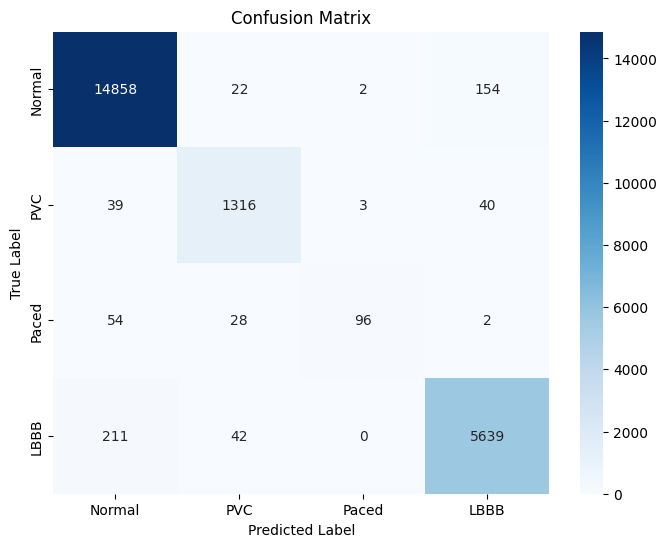

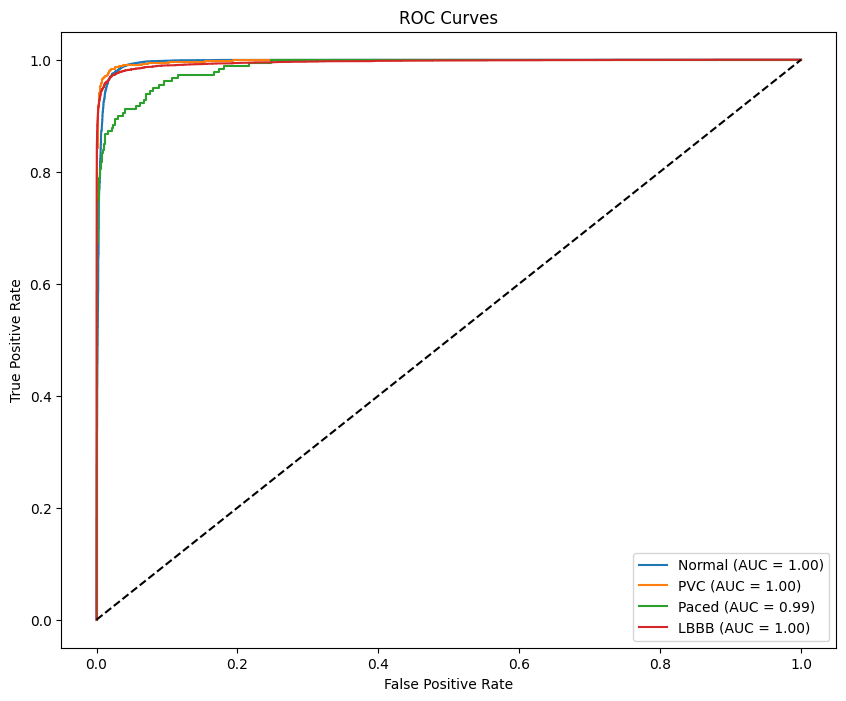

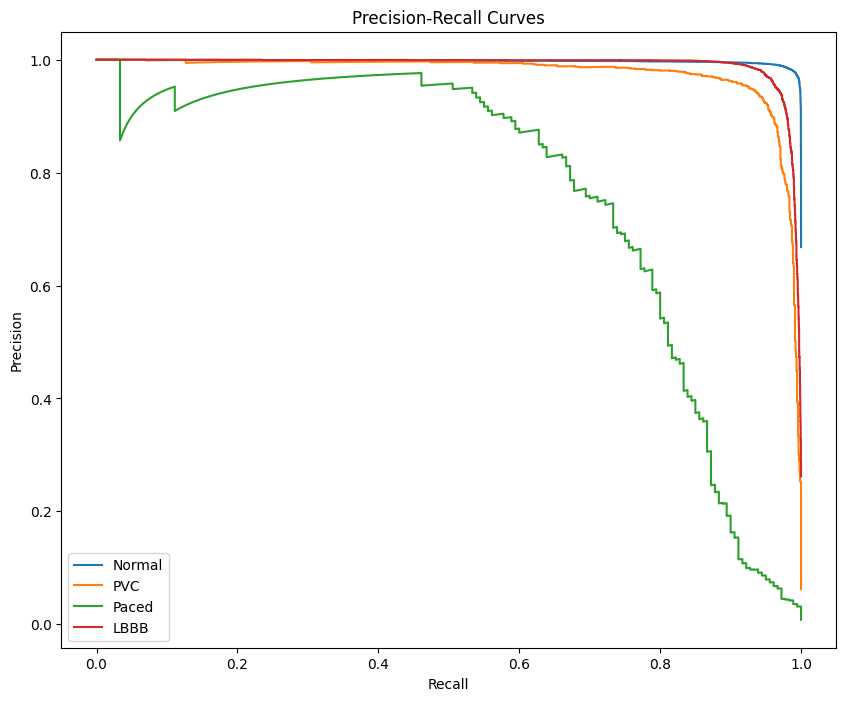

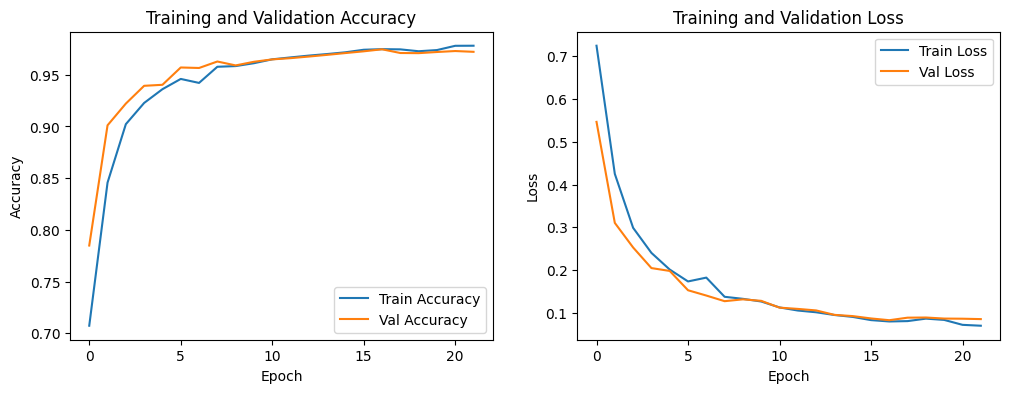

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from scipy.signal import stft
import os
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# [Previous conv_fan_block, fc_fan_block, build_cfan_model functions remain unchanged]

# Bootstrap CI calculation
def bootstrap_ci(data, n_bootstrap=1000, alpha=0.05):
    bootstrapped_scores = []
    n = len(data)
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, n, n)
        score = np.mean(data[indices])
        bootstrapped_scores.append(score)
    lower = np.percentile(bootstrapped_scores, 100 * alpha / 2)
    upper = np.percentile(bootstrapped_scores, 100 * (1 - alpha / 2))
    return lower, upper

# Find optimal threshold using Youden's J statistic
def find_optimal_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    J = tpr - fpr  # Youden's J statistic
    optimal_idx = np.argmax(J)
    return thresholds[optimal_idx]

# Comprehensive evaluation function
def evaluate_model(model, X_test, y_test, class_names=['Normal', 'PVC', 'Paced', 'LBBB']):
    y_pred_proba = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    n_classes = y_test.shape[1]
    
    # Find optimal threshold per class (using validation set ideally, here approximated with test)
    optimal_thresholds = [find_optimal_threshold(y_test[:, i], y_pred_proba[:, i]) for i in range(n_classes)]
    primary_threshold = 0.5  # Default threshold
    
    # Predictions at primary threshold
    y_pred = (y_pred_proba >= primary_threshold).astype(int)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Overall Metrics
    accuracy = np.mean(y_pred_labels == y_true)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred_labels, average='macro')
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred_labels, average='weighted')
    auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    
    print("\nModel Performance on Internal Test Set")
    print("\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Macro precision: {prec_macro:.4f}")
    print(f"Macro recall: {rec_macro:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro precision: {prec_weighted:.4f}")
    print(f"Macro recall: {rec_weighted:.4f}") 
    print(f"Macro AUC: {auc_macro:.4f}")
    
    # Per-Class Metrics
    print("\nPer-Class Metrics (Threshold = 0.5):")
    print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'Specificity':<12} {'F1-Score':<10} {'AUC':<10}")
    print("-" * 65)
    
    per_class_metrics = []
    for i in range(n_classes):
        true_binary = (y_true == i).astype(int)
        pred_binary = (y_pred_labels == i).astype(int)
        proba_binary = y_pred_proba[:, i]
        
        tn, fp, fn, tp = confusion_matrix(true_binary, pred_binary).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        auc = roc_auc_score(true_binary, proba_binary)
        
        prec_lower, prec_upper = bootstrap_ci(true_binary[pred_binary == 1])
        rec_lower, rec_upper = bootstrap_ci(true_binary[pred_binary == 1])
        
        per_class_metrics.append((precision, recall, specificity, f1, auc))
        print(f"{class_names[i]:<10} {precision:<10.4f} {recall:<10.4f} {specificity:<12.4f} {f1:<10.4f} {auc:<10.4f}")
        print(f"{'':<10} ({prec_lower:.2f}-{prec_upper:.2f}) ({rec_lower:.2f}-{rec_upper:.2f})")
    
    print(f"\nOperating Point: Primary decision threshold = {primary_threshold}")
    print(f"Optimal thresholds per class (Youden's J): {optimal_thresholds}")
    print("95% Confidence Intervals reported using bootstrapping method")
    
    # Visualizations
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # 2. ROC Curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        auc = per_class_metrics[i][4]
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()
    
    # 3. Precision-Recall Curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.show()

# Modified training function
def train_model():
    model = build_cfan_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    batch_size = 995
    max_epochs = 300
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=5, 
                                                      restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=max_epochs,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping],
                        verbose=1)
    
    # Evaluate with visualizations
    evaluate_model(model, X_test, y_test)
    
    return model, history

if __name__ == "__main__":
    model, history = train_model()
    
    # Training history plots
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

### ECG ID dataset

In [87]:
!pip install -q wfdb

In [88]:
# Data Handling and Processing
import numpy as np
import pandas as pd
import os
import shutil
import csv
import itertools
import collections
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Signal Processing
import pywt
from scipy import stats
import wfdb

In [89]:
record = '/kaggle/input/ecg-id/ecg-id-database-1.0.0/RECORDS'

In [90]:
records = []  # Initialize an empty list

with open(record, 'r') as f:
    records.extend(line.strip() for line in f)  # Read and strip newline characters

print(records)


['Person_01/rec_1', 'Person_01/rec_2', 'Person_01/rec_3', 'Person_01/rec_4', 'Person_01/rec_5', 'Person_01/rec_6', 'Person_01/rec_7', 'Person_01/rec_8', 'Person_01/rec_9', 'Person_01/rec_10', 'Person_01/rec_11', 'Person_01/rec_12', 'Person_01/rec_13', 'Person_01/rec_14', 'Person_01/rec_15', 'Person_01/rec_16', 'Person_01/rec_17', 'Person_01/rec_18', 'Person_01/rec_19', 'Person_01/rec_20', 'Person_02/rec_1', 'Person_02/rec_2', 'Person_02/rec_3', 'Person_02/rec_4', 'Person_02/rec_5', 'Person_02/rec_6', 'Person_02/rec_7', 'Person_02/rec_8', 'Person_02/rec_9', 'Person_02/rec_10', 'Person_02/rec_11', 'Person_02/rec_12', 'Person_02/rec_13', 'Person_02/rec_14', 'Person_02/rec_15', 'Person_02/rec_16', 'Person_02/rec_17', 'Person_02/rec_18', 'Person_02/rec_19', 'Person_02/rec_20', 'Person_02/rec_21', 'Person_02/rec_22', 'Person_03/rec_1', 'Person_03/rec_2', 'Person_03/rec_3', 'Person_03/rec_4', 'Person_03/rec_5', 'Person_04/rec_1', 'Person_04/rec_2', 'Person_05/rec_1', 'Person_05/rec_2', 'Perso

In [91]:
record_path = "/kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_1"

record = wfdb.rdrecord(record_path)
ecg_signal = record.p_signal[:, 0]
fs = record.fs
time = np.arange(len(ecg_signal)) / fs

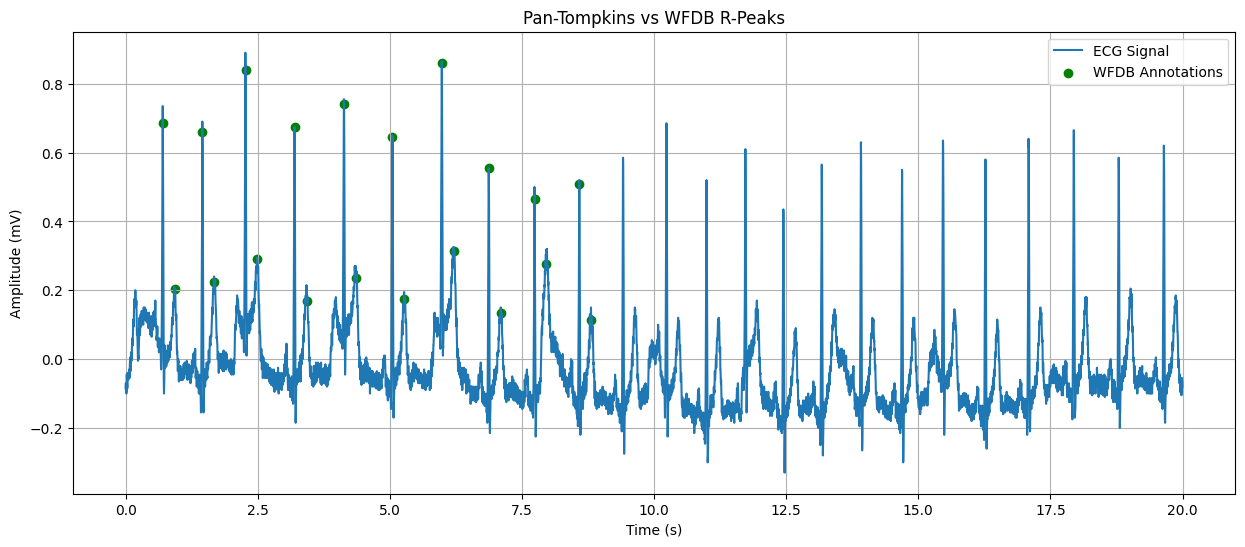

WFDB R-peaks: 20


In [92]:
ann = wfdb.rdann(record_path, 'atr')
true_r_peaks = ann.sample

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time, ecg_signal, label='ECG Signal')
plt.scatter(true_r_peaks / fs, ecg_signal[true_r_peaks], color='green', label='WFDB Annotations', marker='o')
plt.title("Pan-Tompkins vs WFDB R-Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid()
plt.show()

print("WFDB R-peaks:", len(true_r_peaks))

In [93]:
def extract_beats_from_multiple_files(record_list):
    beat_labels = []
    beats = []
    
    for name in record_list:
        record_name = f"/kaggle/input/ecg-id/ecg-id-database-1.0.0/{name}" 
        
        
        try:
            record = wfdb.rdrecord(record_name, channels=[0]) 
            annotation = wfdb.rdann(record_name, 'atr')
            
            # Resample signal to 125 Hz from 360 Hz
            signal = record.p_signal.flatten()  
            # print(signal)
            # print(f"The count of the dat file: {len(signal)}")
            
            # print(len(signal))
            fs = record.fs  
            # print(fs) # 360 hz original
            
            # Get R-peak locations and annotations
            r_peaks = annotation.sample 
            # print(r_peaks)
            ans = name.split('/')[0]
            result = re.search(r'(\d+)$', ans)
            if result:
                label = int(result.group(1))

            labels = annotation.symbol
            
            for i in range(0, len(r_peaks), 2): 
                start = max(0, r_peaks[i] - 80)
                end = min(len(signal), r_peaks[i] + 170)
                beat = signal[start:end]
                beat -= np.mean(beat)
                # print(len(beat))

                # Append only if the extracted beat matches the window size
                if len(beat) == 250:
                    beats.append(beat)
                    beat_labels.append(label)
                    
        except Exception as e:
            print(f"Error processing record {name}: {e}")
            continue
    
    return beat_labels, beats

# Your record list
record_list = ['Person_01/rec_1', 'Person_01/rec_2', 'Person_01/rec_3', 'Person_01/rec_4', 'Person_01/rec_5', 'Person_01/rec_6', 'Person_01/rec_7', 
               'Person_01/rec_8', 'Person_01/rec_9', 'Person_01/rec_10', 'Person_01/rec_11', 'Person_01/rec_12', 'Person_01/rec_13', 'Person_01/rec_14', 
               'Person_01/rec_15', 'Person_01/rec_16', 'Person_01/rec_17', 'Person_01/rec_18', 'Person_01/rec_19', 'Person_01/rec_20', 'Person_02/rec_1',
               'Person_02/rec_2', 'Person_02/rec_3', 'Person_02/rec_4', 'Person_02/rec_5', 'Person_02/rec_6', 'Person_02/rec_7', 'Person_02/rec_8', 
               'Person_02/rec_9', 'Person_02/rec_10', 'Person_02/rec_11', 'Person_02/rec_12', 'Person_02/rec_13', 'Person_02/rec_14', 'Person_02/rec_15', 
               'Person_02/rec_16', 'Person_02/rec_17', 'Person_02/rec_18', 'Person_02/rec_19', 'Person_02/rec_20', 'Person_02/rec_21', 'Person_02/rec_22', 
               'Person_03/rec_1', 'Person_03/rec_2', 'Person_03/rec_3', 'Person_03/rec_4', 'Person_03/rec_5', 'Person_04/rec_1', 'Person_04/rec_2', 
               'Person_05/rec_1', 'Person_05/rec_2', 'Person_06/rec_1', 'Person_06/rec_2', 'Person_07/rec_1', 'Person_07/rec_2', 'Person_08/rec_1', 
               'Person_08/rec_2', 'Person_09/rec_1', 'Person_09/rec_2', 'Person_09/rec_3', 'Person_09/rec_4', 'Person_09/rec_5', 'Person_09/rec_6', 
               'Person_09/rec_7', 'Person_10/rec_1', 'Person_10/rec_2', 'Person_10/rec_3', 'Person_10/rec_4', 'Person_10/rec_5', 'Person_11/rec_1', 
               'Person_11/rec_2', 'Person_11/rec_3', 'Person_12/rec_1', 'Person_12/rec_2', 'Person_13/rec_1', 'Person_13/rec_2', 'Person_14/rec_1', 
               'Person_14/rec_2', 'Person_14/rec_3', 'Person_15/rec_1', 'Person_15/rec_2', 'Person_16/rec_1', 'Person_16/rec_2', 'Person_16/rec_3', 
               'Person_17/rec_1', 'Person_17/rec_2', 'Person_18/rec_1', 'Person_18/rec_2', 'Person_19/rec_1', 'Person_19/rec_2', 'Person_20/rec_1', 
               'Person_20/rec_2', 'Person_21/rec_1', 'Person_21/rec_2', 'Person_21/rec_3', 'Person_22/rec_1', 'Person_22/rec_2', 'Person_23/rec_1', 
               'Person_23/rec_2', 'Person_24/rec_1', 'Person_24/rec_2', 'Person_24/rec_3', 'Person_24/rec_4', 'Person_24/rec_5', 'Person_25/rec_1', 
               'Person_25/rec_2', 'Person_25/rec_3', 'Person_25/rec_4', 'Person_25/rec_5', 'Person_26/rec_1', 'Person_26/rec_2', 'Person_26/rec_3', 
               'Person_26/rec_4', 'Person_27/rec_1', 'Person_27/rec_2', 'Person_27/rec_3', 'Person_28/rec_1', 'Person_28/rec_2', 'Person_28/rec_3', 
               'Person_28/rec_4', 'Person_28/rec_5', 'Person_29/rec_1', 'Person_29/rec_2', 'Person_30/rec_1', 'Person_30/rec_2', 'Person_30/rec_3', 
               'Person_30/rec_4', 'Person_30/rec_5', 'Person_31/rec_1', 'Person_31/rec_2', 'Person_32/rec_1', 'Person_32/rec_2', 'Person_32/rec_3', 
               'Person_32/rec_4', 'Person_32/rec_5', 'Person_32/rec_6', 'Person_33/rec_1', 'Person_33/rec_2', 'Person_34/rec_1', 'Person_34/rec_2', 
               'Person_34/rec_3', 'Person_34/rec_4', 'Person_34/rec_5', 'Person_35/rec_1', 'Person_35/rec_2', 'Person_35/rec_3', 'Person_35/rec_4', 
               'Person_35/rec_5', 'Person_36/rec_1', 'Person_36/rec_2', 'Person_36/rec_3', 'Person_36/rec_4', 'Person_36/rec_5', 'Person_37/rec_1', 
               'Person_37/rec_2', 'Person_38/rec_1', 'Person_38/rec_2', 'Person_39/rec_1', 'Person_39/rec_2', 'Person_40/rec_1', 'Person_40/rec_2', 
               'Person_40/rec_3', 'Person_40/rec_4', 'Person_41/rec_1', 'Person_41/rec_2', 'Person_42/rec_1', 'Person_42/rec_2', 'Person_42/rec_3', 
               'Person_42/rec_4', 'Person_43/rec_1', 'Person_43/rec_2', 'Person_44/rec_1', 'Person_44/rec_2', 'Person_45/rec_1', 'Person_45/rec_2', 
               'Person_46/rec_1', 'Person_46/rec_2', 'Person_46/rec_3', 'Person_46/rec_4', 'Person_46/rec_5', 'Person_47/rec_1', 'Person_47/rec_2', 
               'Person_48/rec_1', 'Person_48/rec_2', 'Person_49/rec_1', 'Person_49/rec_2', 'Person_50/rec_1', 'Person_50/rec_2', 'Person_51/rec_1', 
               'Person_51/rec_2', 'Person_51/rec_3', 'Person_51/rec_4', 'Person_52/rec_1', 'Person_52/rec_2', 'Person_52/rec_3', 'Person_52/rec_4', 
               'Person_52/rec_5', 'Person_52/rec_6', 'Person_52/rec_7', 'Person_52/rec_8', 'Person_52/rec_9', 'Person_52/rec_10', 'Person_52/rec_11', 
               'Person_53/rec_1', 'Person_53/rec_2', 'Person_53/rec_3', 'Person_53/rec_4', 'Person_53/rec_5', 'Person_54/rec_1', 'Person_54/rec_2', 
               'Person_55/rec_1', 'Person_55/rec_2', 'Person_56/rec_1', 'Person_56/rec_2', 'Person_57/rec_1', 'Person_57/rec_2', 'Person_57/rec_3', 
               'Person_58/rec_1', 'Person_58/rec_2', 'Person_59/rec_1', 'Person_59/rec_2', 'Person_59/rec_3', 'Person_59/rec_4', 'Person_59/rec_5', 
               'Person_60/rec_1', 'Person_60/rec_2', 'Person_60/rec_3', 'Person_61/rec_1', 'Person_61/rec_2', 'Person_61/rec_3', 'Person_61/rec_4', 
               'Person_62/rec_1', 'Person_62/rec_2', 'Person_62/rec_3', 'Person_63/rec_1', 'Person_63/rec_2', 'Person_63/rec_3', 'Person_63/rec_4', 
               'Person_63/rec_5', 'Person_63/rec_6', 'Person_64/rec_1', 'Person_64/rec_2', 'Person_64/rec_3', 'Person_65/rec_1', 'Person_65/rec_2', 
               'Person_66/rec_1', 'Person_66/rec_2', 'Person_67/rec_1', 'Person_67/rec_2', 'Person_67/rec_3', 'Person_68/rec_1', 'Person_68/rec_2', 
               'Person_69/rec_1', 'Person_69/rec_2', 'Person_70/rec_1', 'Person_70/rec_2', 'Person_70/rec_3', 'Person_71/rec_1', 'Person_71/rec_2', 
               'Person_71/rec_3', 'Person_71/rec_4', 'Person_71/rec_5', 'Person_72/rec_1', 'Person_72/rec_2', 'Person_72/rec_3', 'Person_72/rec_4', 
               'Person_72/rec_5', 'Person_72/rec_6', 'Person_72/rec_7', 'Person_72/rec_8', 'Person_73/rec_1', 'Person_73/rec_2', 'Person_74/rec_1', 
               'Person_75/rec_1', 'Person_75/rec_2', 'Person_75/rec_3', 'Person_76/rec_1', 'Person_76/rec_2', 'Person_76/rec_3', 'Person_77/rec_1', 
               'Person_77/rec_2', 'Person_77/rec_3', 'Person_78/rec_1', 'Person_78/rec_2', 'Person_79/rec_1', 'Person_79/rec_2', 'Person_80/rec_1', 
               'Person_80/rec_2', 'Person_81/rec_1', 'Person_81/rec_2', 'Person_82/rec_1', 'Person_82/rec_2', 'Person_83/rec_1', 'Person_83/rec_2', 
               'Person_84/rec_1', 'Person_84/rec_2', 'Person_85/rec_1', 'Person_85/rec_2', 'Person_85/rec_3', 'Person_86/rec_1', 'Person_86/rec_2', 
               'Person_87/rec_1', 'Person_87/rec_2', 'Person_88/rec_1', 'Person_88/rec_2', 'Person_88/rec_3', 'Person_89/rec_1', 'Person_89/rec_2', 
               'Person_90/rec_1', 'Person_90/rec_2']

# Extract beats and labels
labels, extracted_beats = extract_beats_from_multiple_files(record_list)

# Basic validation
print(f"Total beats extracted: {len(extracted_beats)}")
print(f"Total labels: {len(labels)}")
print(f"Length of first beat: {len(extracted_beats[0]) if extracted_beats else 'N/A'}")

Total beats extracted: 3100
Total labels: 3100
Length of first beat: 250


In [94]:
print("Converting beats to array...")
signals = np.array(extracted_beats)  

print("Creating DataFrame with 250 columns...")
signal_columns = [f"signal_{i}" for i in range(250)] 
df = pd.DataFrame(signals, columns=signal_columns)
df["qrs_label"] = labels

# Save to CSV
csv_path = "mitbih_beats_expanded.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved as '{csv_path}'")

# Validate the CSV
print("Validating CSV...")
df_loaded = pd.read_csv(csv_path)
print(f"CSV Shape: {df_loaded.shape}")
print(f"Sample data:\n{df_loaded.head()}")

# Validate signals and labels shapes
signals_loaded = df_loaded[[f"signal_{i}" for i in range(250)]].values
labels_loaded = df_loaded["qrs_label"].values
print(f"Signals Shape: {signals_loaded.shape}")
print(f"Labels Shape: {labels_loaded.shape}")

Converting beats to array...
Creating DataFrame with 250 columns...
CSV saved as 'mitbih_beats_expanded.csv'
Validating CSV...
CSV Shape: (3100, 251)
Sample data:
   signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0   0.05412   0.04912   0.04412   0.02912   0.02412   0.04412   0.07412   
1  -0.02314  -0.01814  -0.02314  -0.03314  -0.03314  -0.03814  -0.03814   
2   0.03364   0.02364   0.01864   0.01364   0.02364   0.01864   0.00864   
3  -0.04142  -0.02642  -0.01142   0.02358   0.00358  -0.01642  -0.02142   
4   0.02466   0.03466   0.04966   0.03466   0.02966   0.02966   0.02966   

   signal_7  signal_8  signal_9  ...  signal_241  signal_242  signal_243  \
0   0.08412   0.08412   0.09412  ...    -0.13588    -0.13588    -0.12088   
1  -0.03814  -0.03814  -0.03314  ...    -0.05814    -0.06314    -0.06314   
2   0.01864   0.01864   0.01864  ...    -0.15636    -0.17636    -0.20636   
3  -0.04642  -0.06642  -0.06142  ...    -0.07642    -0.07642    -0.09642   
4   0.

In [95]:
import pandas as pd

# Load dataset
csv_file = "/kaggle/working/mitbih_beats_expanded.csv"
df = pd.read_csv(csv_file)

# Separate the last column
label_column = df.iloc[:, -1]  # Extract last column (qrs_label)
df = df.iloc[:, :-1].astype(float)  # Convert all other columns to float

# Reattach the label column
df["qrs_label"] = label_column  # Add label back as the last column

# Save back to CSV
df.to_csv("/kaggle/working/mitbih_beats_expanded.csv", index=False)

# Display info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Columns: 251 entries, signal_0 to qrs_label
dtypes: float64(250), int64(1)
memory usage: 5.9 MB
None


In [96]:
data = pd.read_csv('/kaggle/working/mitbih_beats_expanded.csv')

data.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_241,signal_242,signal_243,signal_244,signal_245,signal_246,signal_247,signal_248,signal_249,qrs_label
0,0.05412,0.04912,0.04412,0.02912,0.02412,0.04412,0.07412,0.08412,0.08412,0.09412,...,-0.13588,-0.13588,-0.12088,-0.12088,-0.11088,-0.09588,-0.10588,-0.10588,-0.12588,1
1,-0.02314,-0.01814,-0.02314,-0.03314,-0.03314,-0.03814,-0.03814,-0.03814,-0.03814,-0.03314,...,-0.05814,-0.06314,-0.06314,-0.06314,-0.06314,-0.06314,-0.04814,-0.03314,-0.02314,1
2,0.03364,0.02364,0.01864,0.01364,0.02364,0.01864,0.00864,0.01864,0.01864,0.01864,...,-0.15636,-0.17636,-0.20636,-0.19136,-0.18636,-0.16136,-0.15136,-0.14636,-0.14636,1
3,-0.04142,-0.02642,-0.01142,0.02358,0.00358,-0.01642,-0.02142,-0.04642,-0.06642,-0.06142,...,-0.07642,-0.07642,-0.09642,-0.09642,-0.09142,-0.09642,-0.09642,-0.08142,-0.07642,1
4,0.02466,0.03466,0.04966,0.03466,0.02966,0.02966,0.02966,0.00966,-0.00034,0.00966,...,-0.14034,-0.15034,-0.18034,-0.18534,-0.20534,-0.19034,-0.18534,-0.16534,-0.16034,1


In [97]:
data.iloc[:, -1].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])

In [98]:
data.iloc[:, -1].value_counts().reset_index().T

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
qrs_label,2,1,52,72,9,63,32,71,10,46,...,12,13,79,65,66,78,89,80,90,74
count,220,200,110,80,70,60,60,50,50,50,...,20,20,20,20,20,20,20,20,20,10


In [99]:
X = data.iloc[:, :-1]
X.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_240,signal_241,signal_242,signal_243,signal_244,signal_245,signal_246,signal_247,signal_248,signal_249
0,0.05412,0.04912,0.04412,0.02912,0.02412,0.04412,0.07412,0.08412,0.08412,0.09412,...,-0.13088,-0.13588,-0.13588,-0.12088,-0.12088,-0.11088,-0.09588,-0.10588,-0.10588,-0.12588
1,-0.02314,-0.01814,-0.02314,-0.03314,-0.03314,-0.03814,-0.03814,-0.03814,-0.03814,-0.03314,...,-0.04314,-0.05814,-0.06314,-0.06314,-0.06314,-0.06314,-0.06314,-0.04814,-0.03314,-0.02314
2,0.03364,0.02364,0.01864,0.01364,0.02364,0.01864,0.00864,0.01864,0.01864,0.01864,...,-0.16136,-0.15636,-0.17636,-0.20636,-0.19136,-0.18636,-0.16136,-0.15136,-0.14636,-0.14636
3,-0.04142,-0.02642,-0.01142,0.02358,0.00358,-0.01642,-0.02142,-0.04642,-0.06642,-0.06142,...,-0.07142,-0.07642,-0.07642,-0.09642,-0.09642,-0.09142,-0.09642,-0.09642,-0.08142,-0.07642
4,0.02466,0.03466,0.04966,0.03466,0.02966,0.02966,0.02966,0.00966,-0.00034,0.00966,...,-0.14534,-0.14034,-0.15034,-0.18034,-0.18534,-0.20534,-0.19034,-0.18534,-0.16534,-0.16034


In [100]:
y = data.iloc[:, -1]
y

0        1
1        1
2        1
3        1
4        1
        ..
3095    90
3096    90
3097    90
3098    90
3099    90
Name: qrs_label, Length: 3100, dtype: int64

In [101]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
# First split into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the train set into train and validation sets with stratification
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Now, check the class distribution in the splits
print("Class distribution in train set:", pd.Series(y_train).value_counts())
print("Class distribution in validation set:", pd.Series(y_valid).value_counts())
print("Class distribution in test set:", pd.Series(y_test).value_counts())

Class distribution in train set: qrs_label
2     132
1     120
52     66
72     48
9      42
     ... 
39     12
37     12
49     12
22     12
74      6
Name: count, Length: 90, dtype: int64
Class distribution in validation set: qrs_label
2     44
1     40
52    22
72    16
9     14
      ..
8      4
4      4
23     4
22     4
74     2
Name: count, Length: 90, dtype: int64
Class distribution in test set: qrs_label
2     44
1     40
52    22
72    16
9     14
      ..
73     4
18     4
29     4
68     4
74     2
Name: count, Length: 90, dtype: int64


In [102]:
# from sklearn.model_selection import train_test_split

# # First, split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [103]:
print(f"The shape of X_train: {X_train.shape}")
print(f"The shape of X_test: {X_test.shape}")
print(f"The shape of X_valid: {X_valid.shape}")
print(f"The length of y_train: {len(y_train)}")
print(f"The length of y_test: {len(y_test)}")
print(f"The shape of y_valid: {len(y_valid)}")

The shape of X_train: (1860, 250)
The shape of X_test: (620, 250)
The shape of X_valid: (620, 250)
The length of y_train: 1860
The length of y_test: 620
The shape of y_valid: 620


In [104]:
X_train = X_train.values
train_x = X_train.reshape(len(X_train), X_train.shape[1],1)
print(np.shape(train_x))
# print(train_x[0])
print(type(train_x))
# X_train = np.array(X_train)

X_test = X_test.values
test_x = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(test_x))
# print(train_x[0])
print(type(test_x))

X_valid = X_valid.values
valid_x = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
print(np.shape(valid_x))
# print(train_x[0])
print(type(valid_x))

(1860, 250, 1)
<class 'numpy.ndarray'>
(620, 250, 1)
<class 'numpy.ndarray'>
(620, 250, 1)
<class 'numpy.ndarray'>


In [105]:
import tensorflow as tf

num_classes = 91
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("Train y shape:", y_train.shape)
print("Valid y shape:", y_valid.shape)
print("Test y shape:", y_test.shape)

Train y shape: (1860, 91)
Valid y shape: (620, 91)
Test y shape: (620, 91)


Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.0105 - loss: 4.6092 - val_accuracy: 0.0710 - val_loss: 4.5187
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.0755 - loss: 4.5011 - val_accuracy: 0.0710 - val_loss: 4.5087
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0727 - loss: 4.5096 - val_accuracy: 0.0129 - val_loss: 4.4933
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0329 - loss: 4.4842 - val_accuracy: 0.0161 - val_loss: 4.4621
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0147 - loss: 4.4711 - val_accuracy: 0.0645 - val_loss: 4.4532
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0618 - loss: 4.4561 - val_accuracy: 0.0645 - val_loss: 4.4182
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0618 - loss: 4.4264 - val_accuracy: 0.0645 - val_loss: 4.4237
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0618 - loss: 4.4258 - val_accuracy: 0.0645 - val_loss: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


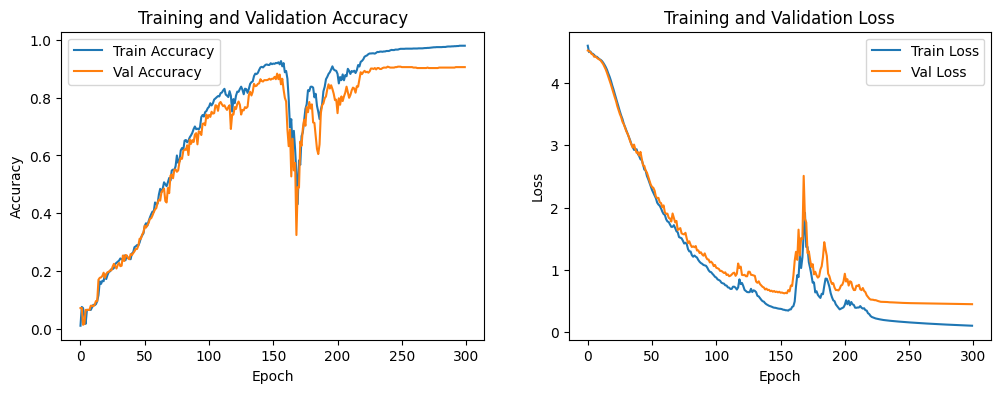

In [106]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from scipy.signal import stft
import os
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Custom CONV-FAN Block (1:1:1 GELU, Sine, Cosine activations)
def conv_fan_block(filters, kernel_size, input_tensor):
    filters_per_act = filters // 3
    gelu_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    gelu_branch = layers.Activation('gelu')(gelu_branch)
    sine_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    sine_branch = layers.Activation(tf.math.sin)(sine_branch)
    cosine_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    cosine_branch = layers.Activation(tf.math.cos)(cosine_branch)
    return layers.Concatenate()([gelu_branch, sine_branch, cosine_branch])

# Custom FC-FAN Block (4:1:1 GELU, Sine, Cosine activations)
def fc_fan_block(units, input_tensor):
    units_gelu = int(units * 4 / 6)
    units_sine = int(units * 1 / 6)
    units_cosine = int(units * 1 / 6)
    gelu_branch = layers.Dense(units_gelu, activation='gelu')(input_tensor)
    sine_branch = layers.Dense(units_sine, activation=tf.math.sin)(input_tensor)
    cosine_branch = layers.Dense(units_cosine, activation=tf.math.cos)(input_tensor)
    return layers.Concatenate()([gelu_branch, sine_branch, cosine_branch])

# CFAN Model for MIT-BIH
def build_cfan_model(input_shape=(250, 1), num_classes=91):  # Note: num_classes=91 as per your code
    inputs = layers.Input(shape=input_shape)
    x = conv_fan_block(filters=96, kernel_size=64, input_tensor=inputs)
    skip = layers.Conv1D(96, kernel_size=64, padding='same', activation='relu')(inputs)
    x = layers.Add()([x, skip])
    x = layers.Activation('relu')(x)
    x = conv_fan_block(filters=96, kernel_size=64, input_tensor=x)
    x = layers.GlobalAveragePooling1D()(x)
    x = fc_fan_block(units=120, input_tensor=x)
    x = fc_fan_block(units=84, input_tensor=x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Bootstrap CI calculation
def bootstrap_ci(data, n_bootstrap=1000, alpha=0.05):
    bootstrapped_scores = []
    n = len(data)
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, n, n)
        score = np.mean(data[indices])
        bootstrapped_scores.append(score)
    lower = np.percentile(bootstrapped_scores, 100 * alpha / 2)
    upper = np.percentile(bootstrapped_scores, 100 * (1 - alpha / 2))
    return lower, upper

# Find optimal threshold using Youden's J statistic
def find_optimal_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    return thresholds[optimal_idx]

# Comprehensive evaluation function
def evaluate_model(model, X_test, y_test, class_names=None):
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_test.shape[1])]  # Default names for 91 classes
    y_pred_proba = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    n_classes = y_test.shape[1]
    
    optimal_thresholds = [find_optimal_threshold(y_test[:, i], y_pred_proba[:, i]) for i in range(n_classes)]
    primary_threshold = 0.5
    
    y_pred = (y_pred_proba >= primary_threshold).astype(int)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Overall Metrics
    accuracy = np.mean(y_pred_labels == y_true)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred_labels, average='macro')
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred_labels, average='weighted')
    # auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    
    print("\nModel Performance on Internal Test Set")
    print("\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Macro precision: {prec_macro:.4f}")
    print(f"Macro recall: {rec_macro:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro precision: {prec_weighted:.4f}")
    print(f"Macro recall: {rec_weighted:.4f}") 
    # print(f"Macro AUC: {auc_macro:.4f}")
    

# Training the Model
def train_model():
    model = build_cfan_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    batch_size = 921
    max_epochs = 300
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=5, 
                                                      restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs = max_epochs,
                        validation_data=(X_valid, y_valid),
                        verbose=1)
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    
    evaluate_model(model, X_test, y_test)
    
    return model, history

if __name__ == "__main__":
    model, history = train_model()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Using the pan + tomspkin

In [107]:
import numpy as np
import scipy.signal as signal

def pan_tompkins(ecg_signal, fs): 
    def bandpass_filter(sig, fs):
        nyq = 0.5 * fs
        low = 5 / nyq
        high = 15 / nyq
        b, a = signal.butter(1, [low, high], btype='band')
        return signal.filtfilt(b, a, sig)

    def derivative(sig):
        return np.ediff1d(sig, to_end=0)

    def squaring(sig):
        return sig ** 2

    def moving_window_integration(sig, window_ms, fs):
        window_size = int(window_ms * fs / 1000)
        window = np.ones(window_size) / window_size
        return np.convolve(sig, window, mode='same')

    def detect_peaks(integrated_sig, fs):
        threshold = np.mean(integrated_sig)
        min_distance = int(0.787 * fs) 
        peaks, _ = signal.find_peaks(integrated_sig, height=threshold, distance=min_distance)
        return peaks

    # Apply Pan-Tompkins steps
    filtered = bandpass_filter(ecg_signal, fs)
    diff = derivative(filtered)
    squared = squaring(diff)
    mwi = moving_window_integration(squared, 150, fs)
    r_peaks = detect_peaks(mwi, fs)

    return r_peaks

In [108]:
def extract_beats_from_multiple_files(record_list):
    beat_labels = []
    beats = []
    
    for name in record_list:
        record_name = f"/kaggle/input/ecg-id/ecg-id-database-1.0.0/{name}" 
        
        
        try:
            record = wfdb.rdrecord(record_name)
            ecg_signal = record.p_signal[:, 0]
            fs = record.fs

            # Detect R-peaks using the Pan-Tompkins algorithm
            r_peaks = pan_tompkins(ecg_signal, fs)
            ans = name.split('/')[0]
            result = re.search(r'(\d+)$', ans)
            if result:
                label = int(result.group(1))
            
            for i in range(0, len(r_peaks)): 
                start = max(0, r_peaks[i] - 80)
                end = min(len(ecg_signal), r_peaks[i] + 170)
                beat = ecg_signal[start:end]
                beat -= np.mean(beat)

                # Append only if the extracted beat matches the window size
                if len(beat) == 250:
                    beats.append(beat)
                    beat_labels.append(label)
                    
        except Exception as e:
            print(f"Error processing record {name}: {e}")
            continue
    
    return beat_labels, beats

# Your record list
record_list = ['Person_01/rec_1', 'Person_01/rec_2', 'Person_01/rec_3', 'Person_01/rec_4', 'Person_01/rec_5', 'Person_01/rec_6', 'Person_01/rec_7', 
               'Person_01/rec_8', 'Person_01/rec_9', 'Person_01/rec_10', 'Person_01/rec_11', 'Person_01/rec_12', 'Person_01/rec_13', 'Person_01/rec_14', 
               'Person_01/rec_15', 'Person_01/rec_16', 'Person_01/rec_17', 'Person_01/rec_18', 'Person_01/rec_19', 'Person_01/rec_20', 'Person_02/rec_1',
               'Person_02/rec_2', 'Person_02/rec_3', 'Person_02/rec_4', 'Person_02/rec_5', 'Person_02/rec_6', 'Person_02/rec_7', 'Person_02/rec_8', 
               'Person_02/rec_9', 'Person_02/rec_10', 'Person_02/rec_11', 'Person_02/rec_12', 'Person_02/rec_13', 'Person_02/rec_14', 'Person_02/rec_15', 
               'Person_02/rec_16', 'Person_02/rec_17', 'Person_02/rec_18', 'Person_02/rec_19', 'Person_02/rec_20', 'Person_02/rec_21', 'Person_02/rec_22', 
               'Person_03/rec_1', 'Person_03/rec_2', 'Person_03/rec_3', 'Person_03/rec_4', 'Person_03/rec_5', 'Person_04/rec_1', 'Person_04/rec_2', 
               'Person_05/rec_1', 'Person_05/rec_2', 'Person_06/rec_1', 'Person_06/rec_2', 'Person_07/rec_1', 'Person_07/rec_2', 'Person_08/rec_1', 
               'Person_08/rec_2', 'Person_09/rec_1', 'Person_09/rec_2', 'Person_09/rec_3', 'Person_09/rec_4', 'Person_09/rec_5', 'Person_09/rec_6', 
               'Person_09/rec_7', 'Person_10/rec_1', 'Person_10/rec_2', 'Person_10/rec_3', 'Person_10/rec_4', 'Person_10/rec_5', 'Person_11/rec_1', 
               'Person_11/rec_2', 'Person_11/rec_3', 'Person_12/rec_1', 'Person_12/rec_2', 'Person_13/rec_1', 'Person_13/rec_2', 'Person_14/rec_1', 
               'Person_14/rec_2', 'Person_14/rec_3', 'Person_15/rec_1', 'Person_15/rec_2', 'Person_16/rec_1', 'Person_16/rec_2', 'Person_16/rec_3', 
               'Person_17/rec_1', 'Person_17/rec_2', 'Person_18/rec_1', 'Person_18/rec_2', 'Person_19/rec_1', 'Person_19/rec_2', 'Person_20/rec_1', 
               'Person_20/rec_2', 'Person_21/rec_1', 'Person_21/rec_2', 'Person_21/rec_3', 'Person_22/rec_1', 'Person_22/rec_2', 'Person_23/rec_1', 
               'Person_23/rec_2', 'Person_24/rec_1', 'Person_24/rec_2', 'Person_24/rec_3', 'Person_24/rec_4', 'Person_24/rec_5', 'Person_25/rec_1', 
               'Person_25/rec_2', 'Person_25/rec_3', 'Person_25/rec_4', 'Person_25/rec_5', 'Person_26/rec_1', 'Person_26/rec_2', 'Person_26/rec_3', 
               'Person_26/rec_4', 'Person_27/rec_1', 'Person_27/rec_2', 'Person_27/rec_3', 'Person_28/rec_1', 'Person_28/rec_2', 'Person_28/rec_3', 
               'Person_28/rec_4', 'Person_28/rec_5', 'Person_29/rec_1', 'Person_29/rec_2', 'Person_30/rec_1', 'Person_30/rec_2', 'Person_30/rec_3', 
               'Person_30/rec_4', 'Person_30/rec_5', 'Person_31/rec_1', 'Person_31/rec_2', 'Person_32/rec_1', 'Person_32/rec_2', 'Person_32/rec_3', 
               'Person_32/rec_4', 'Person_32/rec_5', 'Person_32/rec_6', 'Person_33/rec_1', 'Person_33/rec_2', 'Person_34/rec_1', 'Person_34/rec_2', 
               'Person_34/rec_3', 'Person_34/rec_4', 'Person_34/rec_5', 'Person_35/rec_1', 'Person_35/rec_2', 'Person_35/rec_3', 'Person_35/rec_4', 
               'Person_35/rec_5', 'Person_36/rec_1', 'Person_36/rec_2', 'Person_36/rec_3', 'Person_36/rec_4', 'Person_36/rec_5', 'Person_37/rec_1', 
               'Person_37/rec_2', 'Person_38/rec_1', 'Person_38/rec_2', 'Person_39/rec_1', 'Person_39/rec_2', 'Person_40/rec_1', 'Person_40/rec_2', 
               'Person_40/rec_3', 'Person_40/rec_4', 'Person_41/rec_1', 'Person_41/rec_2', 'Person_42/rec_1', 'Person_42/rec_2', 'Person_42/rec_3', 
               'Person_42/rec_4', 'Person_43/rec_1', 'Person_43/rec_2', 'Person_44/rec_1', 'Person_44/rec_2', 'Person_45/rec_1', 'Person_45/rec_2', 
               'Person_46/rec_1', 'Person_46/rec_2', 'Person_46/rec_3', 'Person_46/rec_4', 'Person_46/rec_5', 'Person_47/rec_1', 'Person_47/rec_2', 
               'Person_48/rec_1', 'Person_48/rec_2', 'Person_49/rec_1', 'Person_49/rec_2', 'Person_50/rec_1', 'Person_50/rec_2', 'Person_51/rec_1', 
               'Person_51/rec_2', 'Person_51/rec_3', 'Person_51/rec_4', 'Person_52/rec_1', 'Person_52/rec_2', 'Person_52/rec_3', 'Person_52/rec_4', 
               'Person_52/rec_5', 'Person_52/rec_6', 'Person_52/rec_7', 'Person_52/rec_8', 'Person_52/rec_9', 'Person_52/rec_10', 'Person_52/rec_11', 
               'Person_53/rec_1', 'Person_53/rec_2', 'Person_53/rec_3', 'Person_53/rec_4', 'Person_53/rec_5', 'Person_54/rec_1', 'Person_54/rec_2', 
               'Person_55/rec_1', 'Person_55/rec_2', 'Person_56/rec_1', 'Person_56/rec_2', 'Person_57/rec_1', 'Person_57/rec_2', 'Person_57/rec_3', 
               'Person_58/rec_1', 'Person_58/rec_2', 'Person_59/rec_1', 'Person_59/rec_2', 'Person_59/rec_3', 'Person_59/rec_4', 'Person_59/rec_5', 
               'Person_60/rec_1', 'Person_60/rec_2', 'Person_60/rec_3', 'Person_61/rec_1', 'Person_61/rec_2', 'Person_61/rec_3', 'Person_61/rec_4', 
               'Person_62/rec_1', 'Person_62/rec_2', 'Person_62/rec_3', 'Person_63/rec_1', 'Person_63/rec_2', 'Person_63/rec_3', 'Person_63/rec_4', 
               'Person_63/rec_5', 'Person_63/rec_6', 'Person_64/rec_1', 'Person_64/rec_2', 'Person_64/rec_3', 'Person_65/rec_1', 'Person_65/rec_2', 
               'Person_66/rec_1', 'Person_66/rec_2', 'Person_67/rec_1', 'Person_67/rec_2', 'Person_67/rec_3', 'Person_68/rec_1', 'Person_68/rec_2', 
               'Person_69/rec_1', 'Person_69/rec_2', 'Person_70/rec_1', 'Person_70/rec_2', 'Person_70/rec_3', 'Person_71/rec_1', 'Person_71/rec_2', 
               'Person_71/rec_3', 'Person_71/rec_4', 'Person_71/rec_5', 'Person_72/rec_1', 'Person_72/rec_2', 'Person_72/rec_3', 'Person_72/rec_4', 
               'Person_72/rec_5', 'Person_72/rec_6', 'Person_72/rec_7', 'Person_72/rec_8', 'Person_73/rec_1', 'Person_73/rec_2', 'Person_74/rec_1', 
               'Person_75/rec_1', 'Person_75/rec_2', 'Person_75/rec_3', 'Person_76/rec_1', 'Person_76/rec_2', 'Person_76/rec_3', 'Person_77/rec_1', 
               'Person_77/rec_2', 'Person_77/rec_3', 'Person_78/rec_1', 'Person_78/rec_2', 'Person_79/rec_1', 'Person_79/rec_2', 'Person_80/rec_1', 
               'Person_80/rec_2', 'Person_81/rec_1', 'Person_81/rec_2', 'Person_82/rec_1', 'Person_82/rec_2', 'Person_83/rec_1', 'Person_83/rec_2', 
               'Person_84/rec_1', 'Person_84/rec_2', 'Person_85/rec_1', 'Person_85/rec_2', 'Person_85/rec_3', 'Person_86/rec_1', 'Person_86/rec_2', 
               'Person_87/rec_1', 'Person_87/rec_2', 'Person_88/rec_1', 'Person_88/rec_2', 'Person_88/rec_3', 'Person_89/rec_1', 'Person_89/rec_2', 
               'Person_90/rec_1', 'Person_90/rec_2']

# Extract beats and labels
labels, extracted_beats = extract_beats_from_multiple_files(record_list)

# Basic validation
print(f"Total beats extracted: {len(extracted_beats)}")
print(f"Total labels: {len(labels)}")
print(f"Length of first beat: {len(extracted_beats[0]) if extracted_beats else 'N/A'}")

Total beats extracted: 5562
Total labels: 5562
Length of first beat: 250


In [109]:
print("Converting beats to array...")
signals = np.array(extracted_beats)  

print("Creating DataFrame with 250 columns...")
signal_columns = [f"signal_{i}" for i in range(250)] 
df = pd.DataFrame(signals, columns=signal_columns)
df["qrs_label"] = labels

# Save to CSV
csv_path = "mitbih_beats_expanded.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved as '{csv_path}'")

# Validate the CSV
print("Validating CSV...")
df_loaded = pd.read_csv(csv_path)
print(f"CSV Shape: {df_loaded.shape}")
print(f"Sample data:\n{df_loaded.head()}")

# Validate signals and labels shapes
signals_loaded = df_loaded[[f"signal_{i}" for i in range(250)]].values
labels_loaded = df_loaded["qrs_label"].values
print(f"Signals Shape: {signals_loaded.shape}")
print(f"Labels Shape: {labels_loaded.shape}")

Converting beats to array...
Creating DataFrame with 250 columns...
CSV saved as 'mitbih_beats_expanded.csv'
Validating CSV...
CSV Shape: (5562, 251)
Sample data:
   signal_0  signal_1  signal_2  signal_3  signal_4  signal_5  signal_6  \
0  -0.03310  -0.02310  -0.01810  -0.02310  -0.03310  -0.03310  -0.03810   
1   0.02794   0.03294   0.02294   0.01794   0.01294   0.02294   0.01794   
2  -0.04142  -0.02642  -0.01142   0.02358   0.00358  -0.01642  -0.02142   
3   0.02314   0.02814   0.02314   0.03314   0.04814   0.03314   0.02814   
4  -0.00812  -0.00312  -0.00312  -0.01812  -0.02312  -0.02812  -0.02812   

   signal_7  signal_8  signal_9  ...  signal_241  signal_242  signal_243  \
0  -0.03810  -0.03810  -0.03810  ...    -0.04310    -0.05810    -0.06310   
1   0.00794   0.01794   0.01794  ...    -0.16206    -0.15706    -0.17706   
2  -0.04642  -0.06642  -0.06142  ...    -0.07642    -0.07642    -0.09642   
3   0.02814   0.02814   0.00814  ...    -0.14686    -0.14686    -0.14186   
4  -0.

In [110]:
import pandas as pd

# Load dataset
csv_file = "/kaggle/working/mitbih_beats_expanded.csv"
df = pd.read_csv(csv_file)

# Separate the last column
label_column = df.iloc[:, -1]  # Extract last column (qrs_label)
df = df.iloc[:, :-1].astype(float)  # Convert all other columns to float

# Reattach the label column
df["qrs_label"] = label_column  # Add label back as the last column

# Save back to CSV
df.to_csv("/kaggle/working/mitbih_beats_expanded.csv", index=False)

# Display info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5562 entries, 0 to 5561
Columns: 251 entries, signal_0 to qrs_label
dtypes: float64(250), int64(1)
memory usage: 10.7 MB
None


In [111]:
data = pd.read_csv('/kaggle/working/mitbih_beats_expanded.csv')

data.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_241,signal_242,signal_243,signal_244,signal_245,signal_246,signal_247,signal_248,signal_249,qrs_label
0,-0.03310,-0.02310,-0.01810,-0.02310,-0.03310,-0.03310,-0.03810,-0.03810,-0.03810,-0.03810,...,-0.04310,-0.05810,-0.06310,-0.06310,-0.06310,-0.06310,-0.06310,-0.04810,-0.03310,1
1,0.02794,0.03294,0.02294,0.01794,0.01294,0.02294,0.01794,0.00794,0.01794,0.01794,...,-0.16206,-0.15706,-0.17706,-0.20706,-0.19206,-0.18706,-0.16206,-0.15206,-0.14706,1
2,-0.04142,-0.02642,-0.01142,0.02358,0.00358,-0.01642,-0.02142,-0.04642,-0.06642,-0.06142,...,-0.07642,-0.07642,-0.09642,-0.09642,-0.09142,-0.09642,-0.09642,-0.08142,-0.07642,1
3,0.02314,0.02814,0.02314,0.03314,0.04814,0.03314,0.02814,0.02814,0.02814,0.00814,...,-0.14686,-0.14686,-0.14186,-0.15186,-0.18186,-0.18686,-0.20686,-0.19186,-0.18686,1
4,-0.00812,-0.00312,-0.00312,-0.01812,-0.02312,-0.02812,-0.02812,-0.03812,-0.03312,-0.02312,...,-0.05812,-0.06812,-0.08312,-0.09312,-0.09812,-0.09812,-0.09812,-0.07312,-0.07812,1


In [112]:
data.iloc[:, -1].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])

In [113]:
data.iloc[:, -1].value_counts().reset_index().T

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
qrs_label,2,1,52,72,9,32,63,3,25,36,...,90,45,19,31,8,83,65,29,12,74
count,425,388,173,135,133,126,119,109,106,104,...,29,29,29,28,28,28,27,27,26,17


In [114]:
X = data.iloc[:, :-1]
X.head()

,signal_0,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9,...,signal_240,signal_241,signal_242,signal_243,signal_244,signal_245,signal_246,signal_247,signal_248,signal_249
0,-0.03310,-0.02310,-0.01810,-0.02310,-0.03310,-0.03310,-0.03810,-0.03810,-0.03810,-0.03810,...,-0.03310,-0.04310,-0.05810,-0.06310,-0.06310,-0.06310,-0.06310,-0.06310,-0.04810,-0.03310
1,0.02794,0.03294,0.02294,0.01794,0.01294,0.02294,0.01794,0.00794,0.01794,0.01794,...,-0.14206,-0.16206,-0.15706,-0.17706,-0.20706,-0.19206,-0.18706,-0.16206,-0.15206,-0.14706
2,-0.04142,-0.02642,-0.01142,0.02358,0.00358,-0.01642,-0.02142,-0.04642,-0.06642,-0.06142,...,-0.07142,-0.07642,-0.07642,-0.09642,-0.09642,-0.09142,-0.09642,-0.09642,-0.08142,-0.07642
3,0.02314,0.02814,0.02314,0.03314,0.04814,0.03314,0.02814,0.02814,0.02814,0.00814,...,-0.15186,-0.14686,-0.14686,-0.14186,-0.15186,-0.18186,-0.18686,-0.20686,-0.19186,-0.18686
4,-0.00812,-0.00312,-0.00312,-0.01812,-0.02312,-0.02812,-0.02812,-0.03812,-0.03312,-0.02312,...,-0.05812,-0.05812,-0.06812,-0.08312,-0.09312,-0.09812,-0.09812,-0.09812,-0.07312,-0.07812


In [115]:
y = data.iloc[:, -1]
y

0        1
1        1
2        1
3        1
4        1
        ..
5557    90
5558    90
5559    90
5560    90
5561    90
Name: qrs_label, Length: 5562, dtype: int64

In [116]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels
# First split into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the train set into train and validation sets with stratification
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Now, check the class distribution in the splits
print("Class distribution in train set:", pd.Series(y_train).value_counts())
print("Class distribution in validation set:", pd.Series(y_valid).value_counts())
print("Class distribution in test set:", pd.Series(y_test).value_counts())

Class distribution in train set: qrs_label
2     255
1     232
52    103
72     81
9      79
     ... 
29     17
45     17
90     17
12     16
74     11
Name: count, Length: 90, dtype: int64
Class distribution in validation set: qrs_label
2     85
1     78
52    35
9     27
72    27
      ..
31     6
65     5
12     5
29     5
74     3
Name: count, Length: 90, dtype: int64
Class distribution in test set: qrs_label
2     85
1     78
52    35
72    27
9     27
      ..
31     5
12     5
29     5
83     5
74     3
Name: count, Length: 90, dtype: int64


In [117]:
print(f"The shape of X_train: {X_train.shape}")
print(f"The shape of X_test: {X_test.shape}")
print(f"The shape of X_valid: {X_valid.shape}")
print(f"The length of y_train: {len(y_train)}")
print(f"The length of y_test: {len(y_test)}")
print(f"The shape of y_valid: {len(y_valid)}")

The shape of X_train: (3336, 250)
The shape of X_test: (1113, 250)
The shape of X_valid: (1113, 250)
The length of y_train: 3336
The length of y_test: 1113
The shape of y_valid: 1113


In [118]:
X_train = X_train.values
train_x = X_train.reshape(len(X_train), X_train.shape[1],1)
print(np.shape(train_x))
# print(train_x[0])
print(type(train_x))
# X_train = np.array(X_train)

X_test = X_test.values
test_x = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(test_x))
# print(train_x[0])
print(type(test_x))

X_valid = X_valid.values
valid_x = X_valid.reshape(len(X_valid), X_valid.shape[1],1)
print(np.shape(valid_x))
# print(train_x[0])
print(type(valid_x))

(3336, 250, 1)
<class 'numpy.ndarray'>
(1113, 250, 1)
<class 'numpy.ndarray'>
(1113, 250, 1)
<class 'numpy.ndarray'>


In [119]:
import tensorflow as tf

num_classes = 91
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

print("Train y shape:", y_train.shape)
print("Valid y shape:", y_valid.shape)
print("Test y shape:", y_test.shape)

Train y shape: (3336, 91)
Valid y shape: (1113, 91)
Test y shape: (1113, 91)


Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.0151 - loss: 4.6114 - val_accuracy: 0.0225 - val_loss: 4.4535
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.0574 - loss: 4.4208 - val_accuracy: 0.0764 - val_loss: 4.3412
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0730 - loss: 4.3459 - val_accuracy: 0.0764 - val_loss: 4.2870
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0683 - loss: 4.2957 - val_accuracy: 0.0764 - val_loss: 4.2462
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.0731 - loss: 4.2564 - val_accuracy: 0.0755 - val_loss: 4.2223
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0829 - loss: 4.2312 - val_accuracy: 0.0988 - val_loss: 4.1776
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.1033 - loss: 4.1829 - val_accuracy: 0.1006 - val_loss: 4.1376
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.1132 - loss: 4.1382 - val_accuracy: 0.1393 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


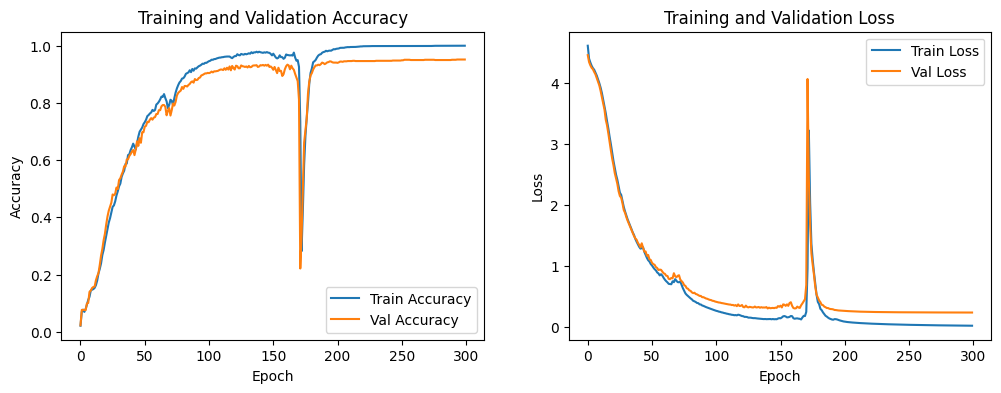

In [120]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from scipy.signal import stft
import os
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Custom CONV-FAN Block (1:1:1 GELU, Sine, Cosine activations)
def conv_fan_block(filters, kernel_size, input_tensor):
    filters_per_act = filters // 3
    gelu_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    gelu_branch = layers.Activation('gelu')(gelu_branch)
    sine_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    sine_branch = layers.Activation(tf.math.sin)(sine_branch)
    cosine_branch = layers.Conv1D(filters_per_act, kernel_size, padding='same')(input_tensor)
    cosine_branch = layers.Activation(tf.math.cos)(cosine_branch)
    return layers.Concatenate()([gelu_branch, sine_branch, cosine_branch])

# Custom FC-FAN Block (4:1:1 GELU, Sine, Cosine activations)
def fc_fan_block(units, input_tensor):
    units_gelu = int(units * 4 / 6)
    units_sine = int(units * 1 / 6)
    units_cosine = int(units * 1 / 6)
    gelu_branch = layers.Dense(units_gelu, activation='gelu')(input_tensor)
    sine_branch = layers.Dense(units_sine, activation=tf.math.sin)(input_tensor)
    cosine_branch = layers.Dense(units_cosine, activation=tf.math.cos)(input_tensor)
    return layers.Concatenate()([gelu_branch, sine_branch, cosine_branch])

# CFAN Model for MIT-BIH
def build_cfan_model(input_shape=(250, 1), num_classes=91):  # Note: num_classes=91 as per your code
    inputs = layers.Input(shape=input_shape)
    x = conv_fan_block(filters=96, kernel_size=64, input_tensor=inputs)
    skip = layers.Conv1D(96, kernel_size=64, padding='same', activation='relu')(inputs)
    x = layers.Add()([x, skip])
    x = layers.Activation('relu')(x)
    x = conv_fan_block(filters=96, kernel_size=64, input_tensor=x)
    x = layers.GlobalAveragePooling1D()(x)
    x = fc_fan_block(units=120, input_tensor=x)
    x = fc_fan_block(units=84, input_tensor=x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Bootstrap CI calculation
def bootstrap_ci(data, n_bootstrap=1000, alpha=0.05):
    bootstrapped_scores = []
    n = len(data)
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, n, n)
        score = np.mean(data[indices])
        bootstrapped_scores.append(score)
    lower = np.percentile(bootstrapped_scores, 100 * alpha / 2)
    upper = np.percentile(bootstrapped_scores, 100 * (1 - alpha / 2))
    return lower, upper

# Find optimal threshold using Youden's J statistic
def find_optimal_threshold(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    return thresholds[optimal_idx]

# Comprehensive evaluation function
def evaluate_model(model, X_test, y_test, class_names=None):
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_test.shape[1])]  # Default names for 91 classes
    y_pred_proba = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    n_classes = y_test.shape[1]
    
    optimal_thresholds = [find_optimal_threshold(y_test[:, i], y_pred_proba[:, i]) for i in range(n_classes)]
    primary_threshold = 0.5
    
    y_pred = (y_pred_proba >= primary_threshold).astype(int)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Overall Metrics
    accuracy = np.mean(y_pred_labels == y_true)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred_labels, average='macro')
    prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred_labels, average='weighted')
    
    # auc_macro = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    
    print("\nModel Performance on Internal Test Set")
    print("\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Macro precision: {prec_macro:.4f}")
    print(f"Macro recall: {rec_macro:.4f}")
    print(f"Weighted F1-Score: {f1_weighted:.4f}")
    print(f"Macro precision: {prec_weighted:.4f}")
    print(f"Macro recall: {rec_weighted:.4f}") 
    # print(f"Macro AUC: {auc_macro:.4f}")
    

# Training the Model
def train_model():
    model = build_cfan_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    batch_size = 921
    max_epochs = 300
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=5, 
                                                      restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs = max_epochs,
                        validation_data=(X_valid, y_valid),
                        verbose=1)
    
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    
    evaluate_model(model, X_test, y_test)
    
    return model, history

if __name__ == "__main__":
    model, history = train_model()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()